### Atmospheric Forward Model Generation



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ExoCTK.pal.forward_models import LineForwardModel

The `LineForwardModel` computes atmospheric forward models , based on the methods described in  [Line & Parmentier 2016](https://ui.adsabs.harvard.edu/#abs/2016ApJ...820...78L/abstract) and [Batalha & Line 2017](https://ui.adsabs.harvard.edu/#abs/2017AJ....153..151B/abstract).
To instantiate a model object we simply provide the directory containing cross-section tables  for the species considered and a path to a Fortran executable, [Chemical Equilibrium with Applications (CEA)](https://www.grc.nasa.gov/www/CEAWeb/), which calculates chemical abundances.

**NOTE**: You may need to recompile  the executable depending on your machine. To do this,  simply run

`gfortran cea2.f -o cea2.x -w`

from the `cea/` directory, substituting `gfortran` for another Fortran compiler  if desired.

In [2]:
initial_model = LineForwardModel('cross-sections/', 'cea/cea2.x')

# Model Parameters


### Planet/Star Parameters
* `Rp` - radius of the planet in units of Jupiter Radii
* `Rstar` - radius of the planet in units of Solar Radii
* `Mp` - mass of the planet in units of Jupiter Mass 

### Temperature-Pressure Profile Parameters

The thermal profile used in the model assumes the atmosphere to be in radiative equilibrium based upon the analytic radiative equilibrium temperature profile of Guillot 2010. This profile assumes one downwelling visible channels of radiation and one upwelling stream of thermal emission.

* `Tirr` - temperature at the top of atmosphere in Kelvin
* `logKir` - log of the Planck mean thermal infrared opacity
* `logg1` - log of the ratio of the Planck mean opacities in the visible stream to the thermal stream

### Chemistry Parameters
* `logMet` - log Metallicity
* `logCtoO` - log of the ratio Carbon to Oxygen abundance
* `logPQC` - log of the pressure of Carbon quenching
* `logPQN` - log of the pressure of Nitrogen quenching

### Cloud Parameters
* `logRayAmp` - log of the amplitude of Rayleigh scattering
* `RaySlp` - Slope of Rayleigh scattering
* `logPc` - Pressure level of cloud deck in mbar

The `LineForwardModel` object is  an [`astropy.modeling.Fittable1DModel`](http://docs.astropy.org/en/stable/modeling/) so we use the  existing `astropy.modeling` tools to find the best-fit model parameters for some data. Let's consider our simulated transmission spectrum from WASP-107b, binned down to  use with the forward model opacity grids.

In [3]:
spec = np.load("../LCFitting/WASP107b-TranSpec.npz")

binned_wave = (spec['binwave'][1::2] + spec['binwave'][0:-1:2])/2
binned_rprs = (spec['rprs'][1::2] + spec['rprs'][0:-1:2])/2
binned_rprserr = np.sqrt((spec['rprserr'][1::2]**2 + spec['rprserr'][0:-1:2]**2))

binned_rprs_sq = binned_rprs**2
binned_rprs_sq_err = 2*binned_rprs*binned_rprserr

We'll start by setting the model parameters to some reasonable initial guess and fixing those which we know well or aren't interested in fitting.

In [4]:
initial_model.Rp = 0.94
initial_model.Mp = 0.12
initial_model.Rstar = 0.66

initial_model.Rp.fixed = False
initial_model.Mp.fixed = True
initial_model.Rstar.fixed = True

initial_model.Tirr = 700.
initial_model.logKir = -1.5
initial_model.logg1 = -1.0

initial_model.logMet = -1.0
initial_model.logCtoO = -0.26
initial_model.logPQC.fixed = True # default is -5
initial_model.logPQN.fixed = True # default is -5

initial_model.logRayAmp.fixed = True # default is 0
initial_model.RaySlp.fixed = True # default is 4
initial_model.logPc = 1.5

We'll use Astropy's Levenburg-Marquardt Least Squares Fitter to get a basic best fit to the data.

In [5]:
from astropy.modeling.fitting import LevMarLSQFitter

fitter = LevMarLSQFitter()
best_fit_model = fitter(initial_model, binned_wave, binned_rprs_sq, weights=1/binned_rprs_sq_err, maxiter=1000)

In [6]:
best_fit_model

<LineForwardModel(Rp=0.9240837099696461, Rstar=0.66, Mp=0.12, Tirr=544.7799500561534, logKir=-4.018327645601417, logg1=-1.693246844847806, logMet=-1.6607970918558914, logCtoO=-0.4287119571012318, logPQC=-5.0, logPQN=-5.0, logRayAmp=0.0, RaySlp=4.0, logPc=1.5)>

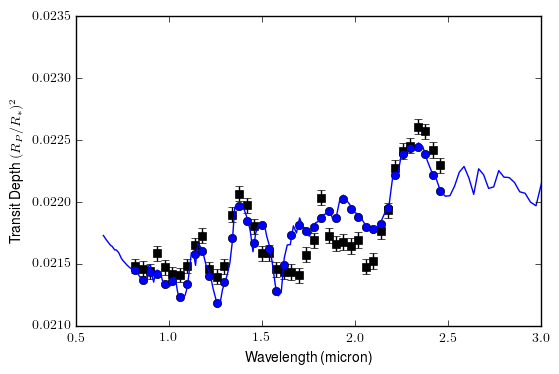

In [8]:
plt.errorbar(binned_wave, binned_rprs_sq, binned_rprs_sq_err, fmt='sk')
plt.plot(binned_wave, best_fit_model(binned_wave), 'bo')
plt.plot(best_fit_model.full_wavelength, best_fit_model.full_flux) # model at the full resolution wavelength grid
plt.xlim(0.5, 3.0)
plt.xlabel('Wavelength (micron)')
plt.ylabel('Transit Depth $(R_P/R_*)^2$')

In [10]:
np.savez("WASP107b-RetrievalSpec.npz", full_wave=best_fit_model.full_wavelength, full_trans=best_fit_model.full_flux,
        data_wave=binned_wave, data_trans=binned_rprs_sq, data_err=binned_rprs_sq_err, model_trans=best_fit_model(binned_wave))

# Citations

The basic transmission code for computing the forward model

[Line, M.R., Knutson, H., Deming, D., Wilkins, A., Desert, J-M. , 2013, A near-infrared transmission spectrum for warm Saturn HAT-P-12b , ApJ, 778](https://ui.adsabs.harvard.edu/#abs/2013ApJ...778..183L/abstract)

[Greene, T. P., Line, M.R., Montero, C., Fortney, J. J., Lustig-Yaeger, J., Luther, K., 2016, Characterizing Transiting Exoplanet Atmospheres with JWST, ApJ, 817](https://ui.adsabs.harvard.edu/#abs/2016ApJ...817...17G/abstract)

[Line, M.R., Parmentier, V., 2016, The Influence of Nonuniform Cloud Cover on Transit Transmission Spectra, ApJ, 820](https://ui.adsabs.harvard.edu/#abs/2016ApJ...820...78L/abstract)

Equilibrium chemistry implementation using the NASA CEA Code:

[Kreidberg L., Line, M.R., Bean, J.L., Stevenson, K.B., Desert, J-M., Madhusudhan, N., Fortney, J.J., Barstow, J.K., Henry, G.W., Williamson, M., Showman, A.P., 2015, A Detection of Water in the Transmission Spectrum of the Hot Jupiter WASP-12b and Implications for its Atmospheric Composition, ApJ, 814](https://ui.adsabs.harvard.edu/#abs/2015ApJ...814...66K/abstract)

[Batalha, N.E., Line, M.R., 2017, Information Content Analysis for Selection of Optimal JWST Observing Modes, AJ, 153](https://ui.adsabs.harvard.edu/#abs/2017AJ....153..151B/abstract)

CEA code, itself:

[Gordon, S., & McBride, B. J. 1994, NASRP, 1311](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19950013764.pdf)

Correlated-K implementation/algorithm should cite:

[Lacis, A., Oinas, V., 1991, JGR, 96](https://pubs.giss.nasa.gov/abs/la01100t.html)

[Amundsen, D.S., Tremblin, P., Manners, J., Baraffe, I., Mayne, N.J., 2017, A&A, 598](https://ui.adsabs.harvard.edu/#abs/2017A&A...598A..97A/abstract)

Line-by-line cross sections :

[Freedman, R.S., Marley, M.S., Lodders, K., 2008, ApJS, 2008](https://ui.adsabs.harvard.edu/#abs/2008ApJS..174..504F/abstract)

[Freedman, R.S., Lustig-Yaeger, J., Fortney, J.J., Lupu, R.E., Marley, M.S., Lodders, K., 2014, ApJS, 214](https://ui.adsabs.harvard.edu/#abs/2014ApJS..214...25F/abstract)